In [1]:
import itertools
from copy import deepcopy as copy

# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
from itertools import chain, permutations, product
from operator import itemgetter
from time import time

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from numpy.linalg import matrix_rank as rank
from scipy.linalg import block_diag, fractional_matrix_power
from utils.Adversary import Adversary
from utils.Conversions import hamming_dist as dist
from utils.Conversions import (
    mask_maker,
    partial,
    to_adversary_mat,
    to_str,
    to_str_list,
    visualize,
)
from utils.Problems import ED, Problem, exact_k, threshold_k
from utils.Solvers import (
    adv_solver,
    instance_mask,
    ket,
    relative_hadamard_norm_max,
    type_mask,
)

mpl.rcParams["figure.dpi"] = 120
from multiprocessing.pool import ThreadPool as Pool

In [2]:
def get_oracles(funcs, oracle_getter, to_list=True):
    print("get_oracles", len(funcs))
    if to_list:
        return [oracle_getter(func) for func in funcs]
    return {func: oracle_getter(func) for func in funcs}


def cycle_oracle(func):
    return permutation_oracle(cycle_to_standard(func))


def get_phase_oracles(problem):
    oracles = {}
    # roots = nthRootsOfUnity(n)
    if isinstance(problem, Problem):
        instances = problem.instances
    n = len(instances[0])
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, i] = -1 if instance[i] == 1 else 1
        oracles[instance] = oracle

    return oracles


def phase_oracle(func):
    oracle = np.zeros((len(func), len(func)))
    for i in range(len(func)):
        oracle[i, i] = func[i]
    return oracle


def get_standard_oracles(problem):
    oracles = {}
    n = problem.n
    alpha_len = len(problem.alphabet)
    for instance in problem.instances:
        oracle = []
        for i in range(n):
            curr_oracle = np.zeros((alpha_len, alpha_len))
            for a in problem.alphabet:
                curr_oracle[a, (instance[i] + a) % alpha_len] = 1
            # print(curr_oracle)
            oracle.append(copy(curr_oracle))
        oracles[instance] = block_diag(*oracle)
        # print(oracles[instance])
    return oracles


def standard_oracle(func, alpha_len=None):
    n = len(func)
    if alpha_len is None:
        alpha_len = n
    oracle = []
    for i in range(n):
        curr_oracle = np.zeros((alpha_len, alpha_len))
        for a in range(alpha_len):
            curr_oracle[a, (func[i] + a) % alpha_len] = 1
            # print(curr_oracle)
        oracle.append(copy(curr_oracle))
    return block_diag(*oracle)


def get_oracle_diffs(oracles, prod=True, mat=False, keys=None, threads=8):
    n = oracles[0].shape[0]
    if np.linalg.norm(np.imag(np.block([oracles]))) == 0:
        oracle_diffs = np.zeros([n * len(oracles)] * 2)
    else:
        print("complex time!")
        oracle_diffs = np.zeros([n * len(oracles)] * 2, dtype=complex)
    # print("keys", keys)
    I = np.eye(oracles[0].shape[0])
    if keys is None:
        keys = list(range(len(oracles)))
    # keys.sort()
    keys = list(range(len(oracles)))

    def diff_map(v):
        v1, v2 = v
        return I - oracles[v1].conj().T @ oracles[v2]

    # counter = 0
    pool = Pool(threads)
    for v1 in keys:
        if not v1 % 100:
            print(v1 / len(oracles))
        oracle_diffs[v1 * n : (v1 + 1) * n] = np.hstack(
            pool.map(diff_map, list(product([v1], keys)))
        )
    return oracle_diffs


def phase_oracle_diffs(perms):
    # phase_mats = [permutation_oracle(perm) for perm in perms]
    diffs = [[_ for _ in range(len(perms))] for _2 in range(len(perms))]
    # print('diffs', diffs)
    n = len(perms[0])
    for i in range(len(perms)):
        for j in range(len(perms)):
            diff = np.zeros((len(perms[i]), len(perms[i])))
            for r in range(n):
                # for c in range(n):
                if perms[i][r] != perms[j][r]:
                    diff[r, r] = 1
            # print('ij', i, j)
            diffs[i][j] = diff
    return diffs


def permutation_oracle(perm, nonstandard=False):
    n = len(perm)

    oracle = np.zeros((n, n))
    for i in range(n):
        oracle[perm[i], i] = 1
    return oracle


def get_permutation_oracles(instances):
    # assuming instances are all lists representing permutations
    oracles = {}
    n = len(instances[0])
    print(n)
    # assert tuple(range(n)) == problem.alphabet
    for instance in instances:
        oracle = np.zeros((n, n))
        for i in range(n):
            oracle[i, instance[i]] = 1
        oracles[instance] = oracle
        # assert oracle@oracle.T - np.eye(n)
    return oracles


def preimage_even_odd(n):
    perms = itertools.permutations(range(n))
    no_instances = []
    yes_instances = []
    for perm in get_cycles(n, n):
        # print(to_str(perm))
        if perm.index(0) >= n // 2:
            yes_instances.append(perm)
        else:
            no_instances.append(perm)
    return Problem(no_instances, yes_instances)

In [7]:
def mask_maker(cases, assignment=None):
    perms = None
    if assignment is None:
        perms = list(chain(*cases))
        assignment = {perm: i for i, perm in enumerate(perms)}
    mat = np.zeros((len(assignment), len(assignment)))
    for case1 in range(len(cases)):
        for case2 in range(len(cases)):
            if case1 != case2:
                for perm1 in cases[case1]:
                    for perm2 in cases[case2]:
                        mat[assignment[perm1], assignment[perm2]] = 1

    return mat


def inversion_sorter(perms):
    n = len(perms)
    perm_classes = [[perm for perm in perms if perm.index(0) == i] for i in range(n)]
    for pc in perm_classes:
        pc.sort()
    return list(chain(*perm_classes))


perm_len = 4
n = 1
m = perm_len - n
perms = list(permutations(range(perm_len)))
perms = inversion_sorter(perms)
print(len(perms))

cases = [
    [perm for perm in perms if perm.index(0) < n],
    [perm for perm in perms if perm.index(0) >= n],
]
problem_mat = mask_maker(cases)
labels = to_str_list(perms)
labels = [labels, labels]
# visualize(problem_mat, labels, title="Problem Mask" + " n=" + str(n) + " m=" + str(m))

24


In [14]:
oracles = get_oracles(perms, permutation_oracle)
oracle_diffs = get_oracle_diffs(oracles)
oracle_diff_diffs = np.block(phase_oracle_diffs(perms))
Lambda, Y, W = relative_hadamard_norm_max(problem_mat, oracle_diffs, len(perms))
Lambda_diff, Y_diff, W_diff = relative_hadamard_norm_max(
    problem_mat, oracle_diff_diffs, len(perms)
)

get_oracles 24
0.0
shapes
(96, 96)
(4, 4)
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Dec 03 01:37:15 PM: Your problem has 1152 variables, 9217 constraints, and 0 parameters.
(CVXPY) Dec 03 01:37:15 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 03 01:37:15 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 03 01:37:15 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 03 01:37:15 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 03 01:37:15 P

C:\Users\Blake\ED_Adversaries\utils\Conversions.py:299: ComplexWarning: Casting complex values to real discards the imaginary part
  G[x,y] = Lambda[x,y]/np.sqrt(mu[x,x] * mu[y,y])


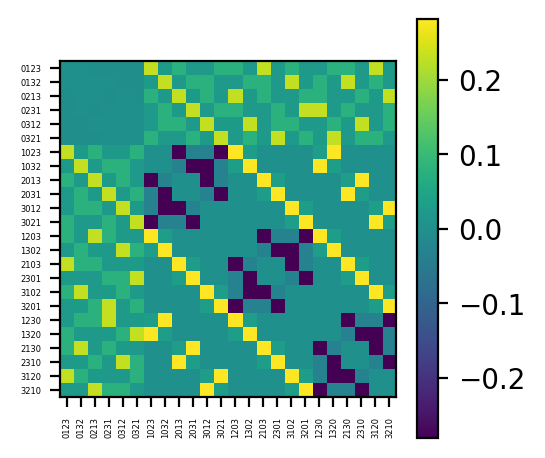

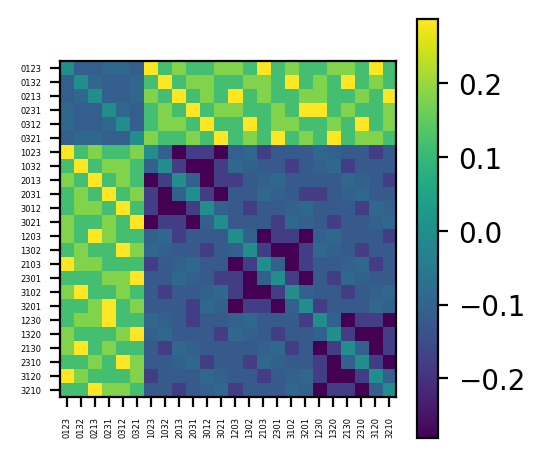

1.0 -1.625
1.275 -1.275


In [15]:
def tensor_mult(A, B):
    a = A.shape[0]
    b = B.shape[0]
    if a >= b:
        big = A
        small = B
    else:
        big = B
        small = A

    return big * np.kron(small, np.ones((big.shape[0] // small.shape[0],) * 2))


G = to_adversary_mat(Lambda, Y)
G_diff_diffs = to_adversary_mat(Lambda_diff, Y_diff)
visualize(G, labels)
visualize(G_diff_diffs, labels)
G_diff = tensor_mult(
    G,
    oracle_diffs,
)
truncated = tensor_mult(G * problem_mat, oracle_diffs)
evals, evects = np.linalg.eigh(G_diff)
tevals, tevects = np.linalg.eigh(truncated)
evals = np.round(evals, 3)
tevals = np.round(tevals, 3)
print(np.max(evals), np.min(evals))
print(np.max(tevals), np.min(tevals))

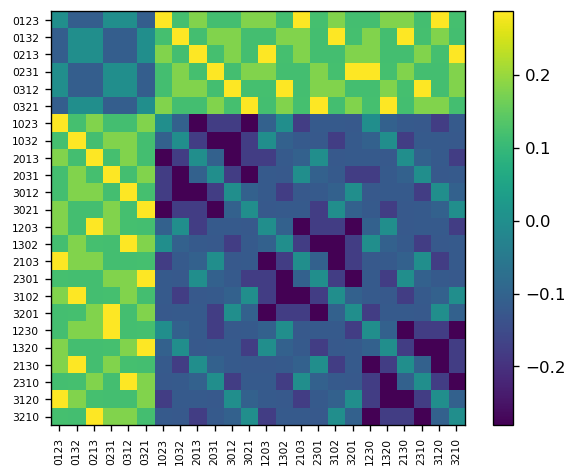

1.0000000021357451 1.732050809703403


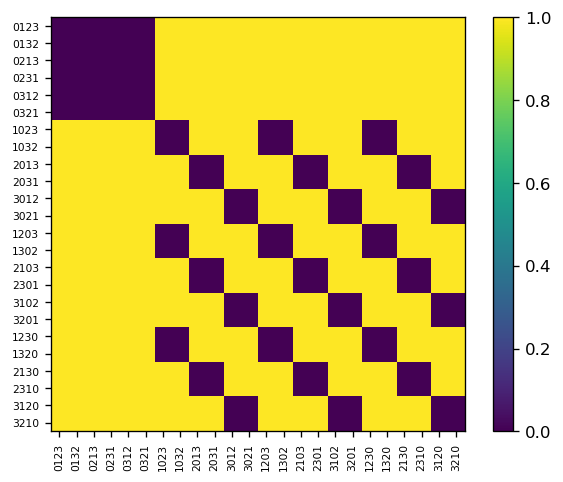

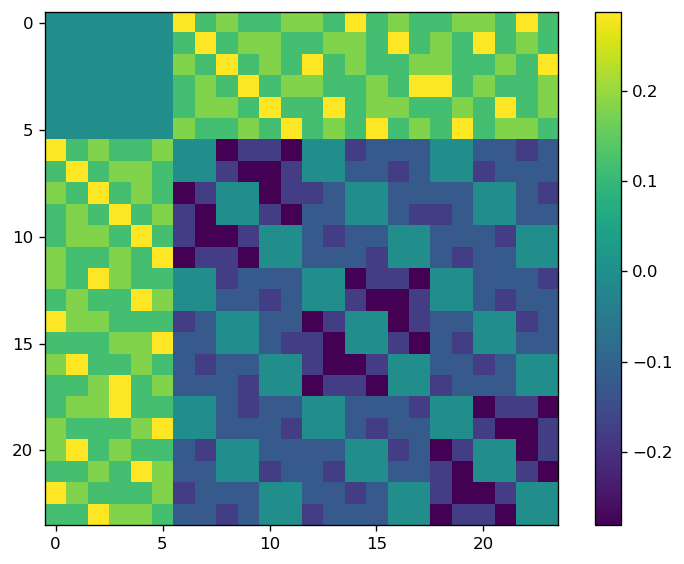

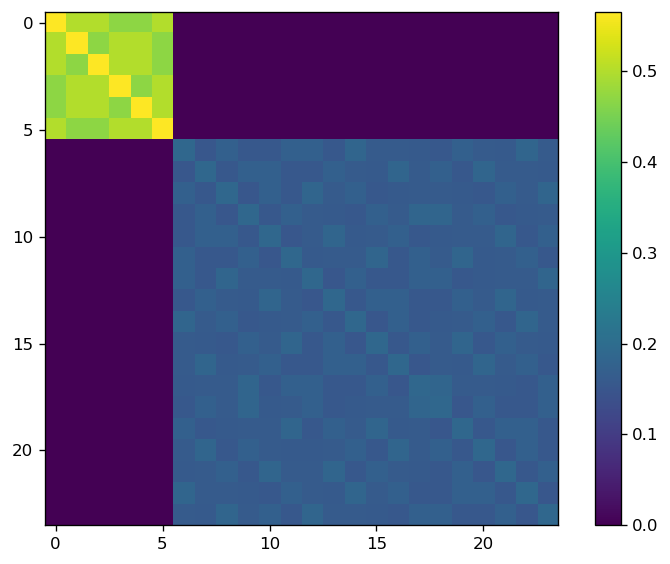

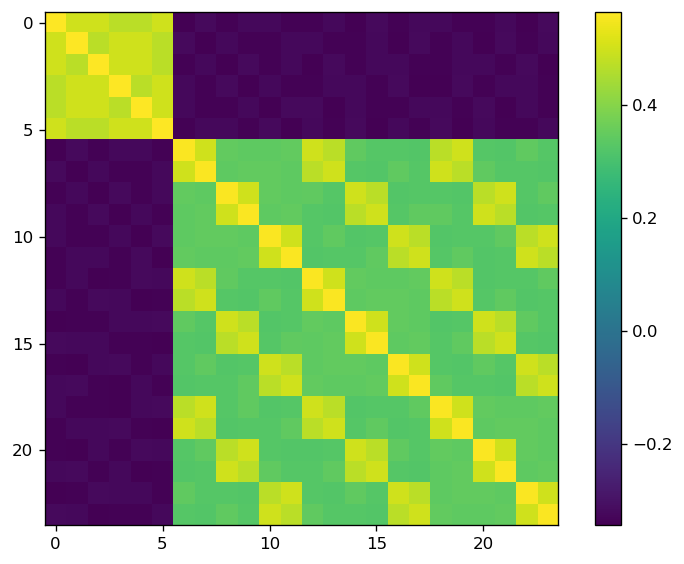

In [70]:
visualize(np.where(np.abs(G_diff_diffs) >= 0.1, G_diff_diffs, 0), labels)
G_dt = np.where(np.abs(G_diff_diffs) >= 0.1, G_diff_diffs, 0)
p = partial(perms, 0)
G_dt = p * G_dt
print(np.max(np.linalg.eigvalsh(G_dt)), np.max(np.linalg.eigvalsh(G_dt * problem_mat)))
visualize(p, labels)
visualize(G_dt)
visualize((problem_mat * G_dt) @ (problem_mat * G_dt))
visualize(G_dt @ G_dt)

True


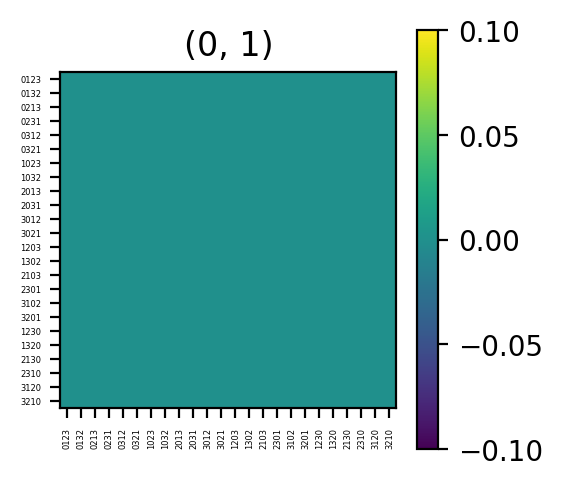

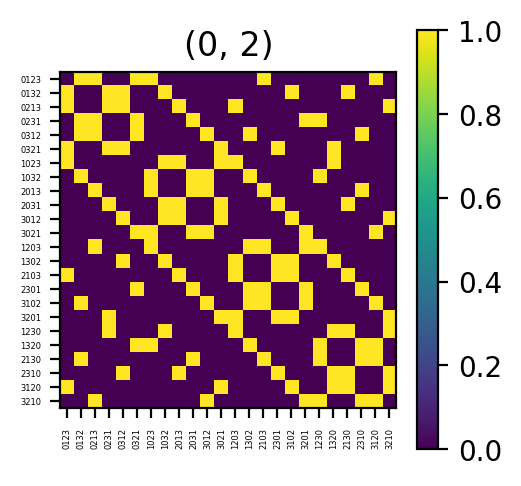

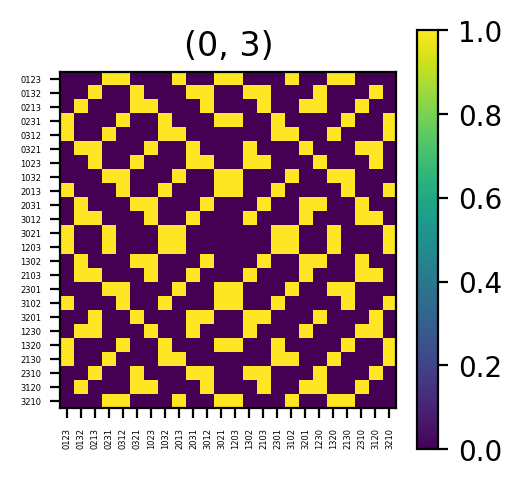

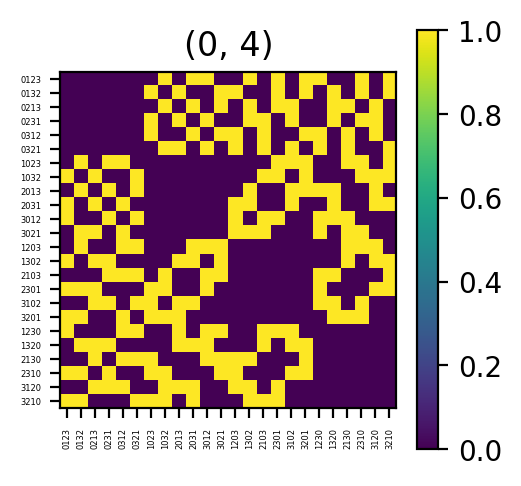

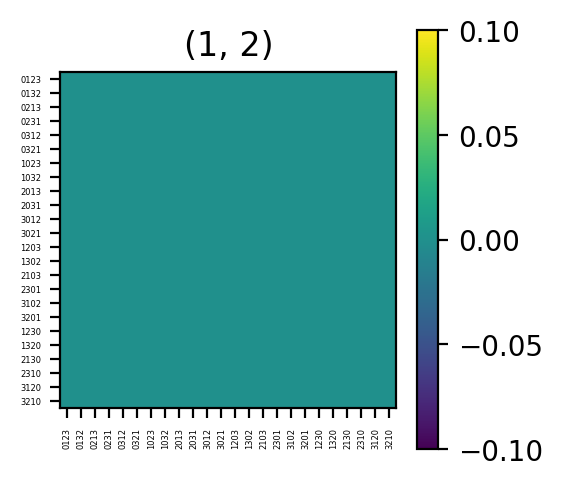

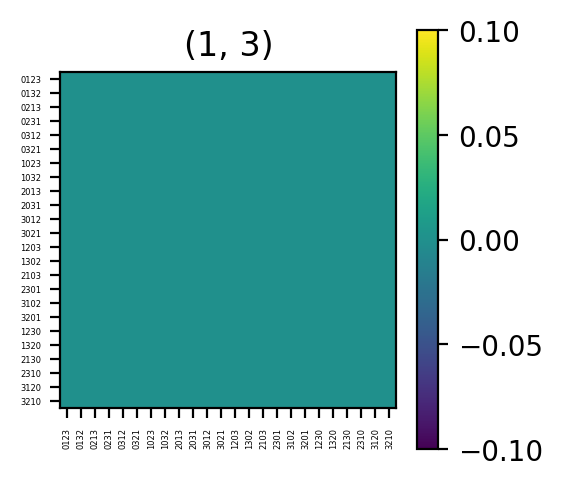

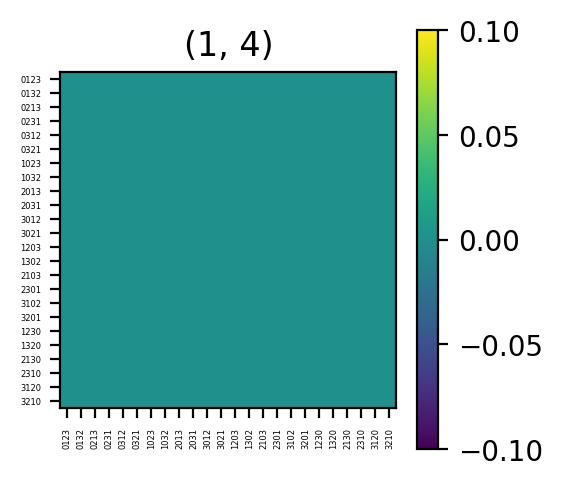

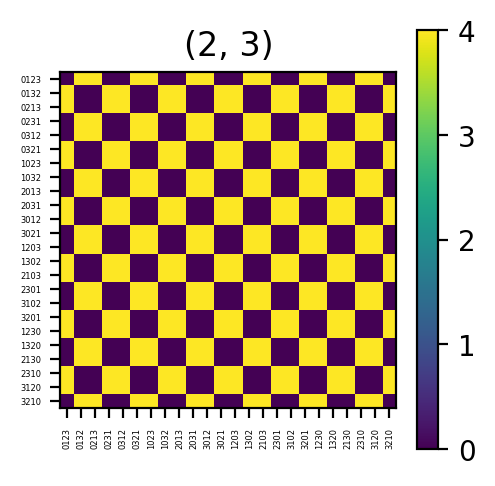

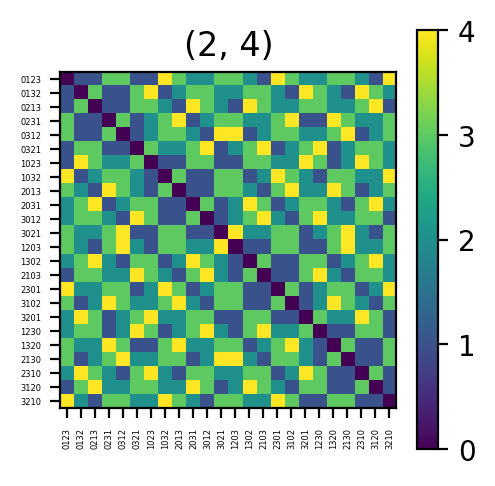

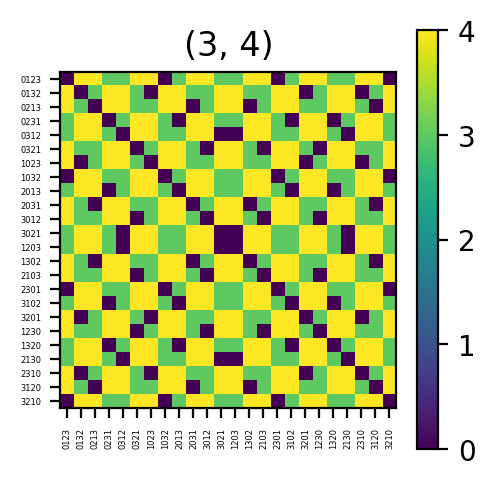

In [13]:
from numpy.linalg import norm


def hamming_scheme(rows, columns=None):
    if columns is None:
        columns = rows
    n = len(rows[0])
    mats = [np.zeros((len(rows), len(columns))) for _ in range(n + 1)]
    for i, r in enumerate(rows):
        for j, c in enumerate(columns):
            mats[dist(r, c)][i, j] = 1
    return mats


def is_association_scheme(scheme):
    shape = scheme[0].shape
    if norm(scheme[0] - np.eye(shape[0])):
        print("no identity")
        return False

    if norm(np.sum(scheme, axis=0) - np.ones(shape)):
        print("not all ones")
        return False

    for mat1 in scheme:
        for mat2 in scheme:
            if norm(mat1 @ mat2 - mat2 @ mat1):
                print("does not commute")
                visualize(mat1 + 1j * mat2)
                return False
    return True


def decompose_scheme(scheme, mask):
    scheme = copy(scheme)
    I = scheme[0]
    scheme = scheme[1:]
    return (
        [I]
        + [mask * A for A in scheme]
        + [(np.ones(mask.shape) - mask) * A for A in scheme]
    )


def decomp_hamming_scheme(instances, mask):
    return decompose_scheme(hamming_scheme(instances), mask)


dpi = 200
# size = 600 / dpi
plt.rcParams["figure.dpi"] = dpi
plt.rcParams["figure.figsize"] = (size, size)
# print(cases[0], cases[0])
# mats = decomp_hamming_scheme(cases[0], problem_matm)
scheme = hamming_scheme(perms)
print(is_association_scheme(scheme))
# for i, mat in enumerate(scheme):
    # visualize(mat, labels)
for i in range(len(scheme)):
    for j in range(i+1,len(scheme)):
        mat1 = scheme[i]
        mat2 = scheme[j]
        visualize(mat1 @ mat2, labels, title=str((i,j)))

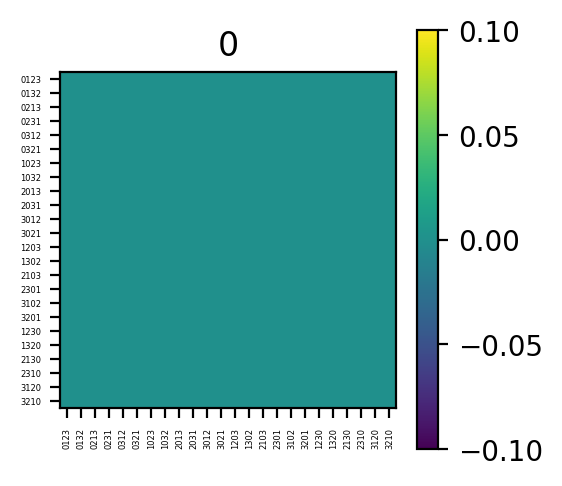

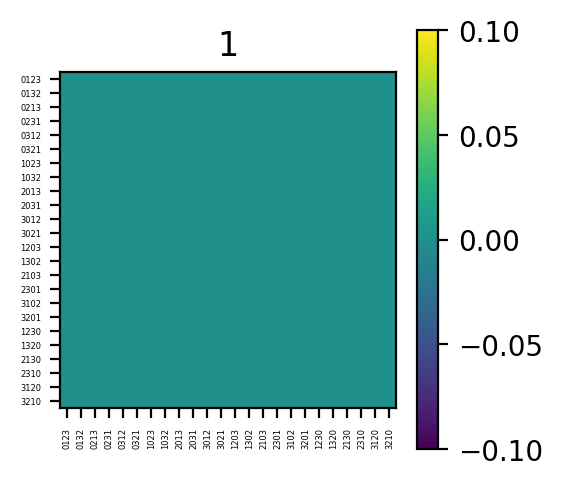

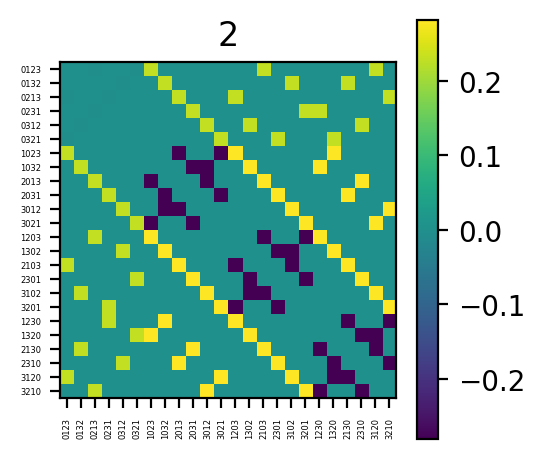

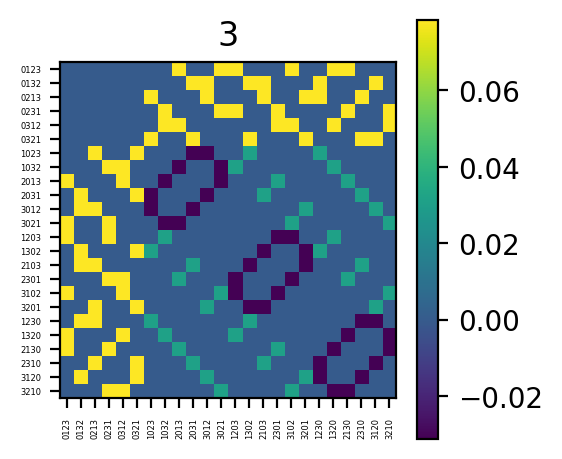

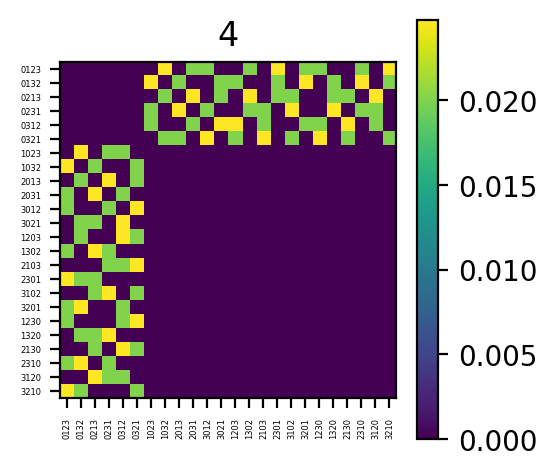

In [16]:
for i, mat in enumerate(scheme):
    visualize(mat * G, labels, title=str(i))

In [19]:
def get_stablizers(perms, stable_sets):
    stabilizers = []
    for perm in perms:
        stable_count = 0
        for stable in stable_sets:
            if set(perm[stable] for stable in stable) != stable:
                break
            stable_count += 1 
        if stable_count == len(stable_sets):
            stabilizers.append(perm)
    return stabilizers

stable_sets = [set(range(n)), set(range(n, perm_len))]
stabilizers = get_stablizers(perms, stable_sets)
print(stabilizers)

[(0, 1, 2, 3), (0, 1, 3, 2), (0, 2, 1, 3), (0, 2, 3, 1), (0, 3, 1, 2), (0, 3, 2, 1)]
